Quite a while ago I did a [blog post](http://rdkit.blogspot.co.at/2015/08/tuning-substructure-queries.html) describing a method to exert more control over the way substructure queries match. The approach described in that post has since been integrated into the RDKit.

This post shows how to use the approach from Python and directly within the RDKit PostgreSQL cartridge.

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
%load_ext sql
print(rdBase.rdkitVersion)
import time
print(time.asctime())

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
2016.09.1.dev1
Fri Jul 22 09:54:46 2016


Our starting point is a query against ChEMBL for molecules that contain a phenyl ring with a substituent.

In [19]:
data = %sql postgresql://localhost/chembl_21 \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>'c1ccccn1'::mol limit 10;

10 rows affected.


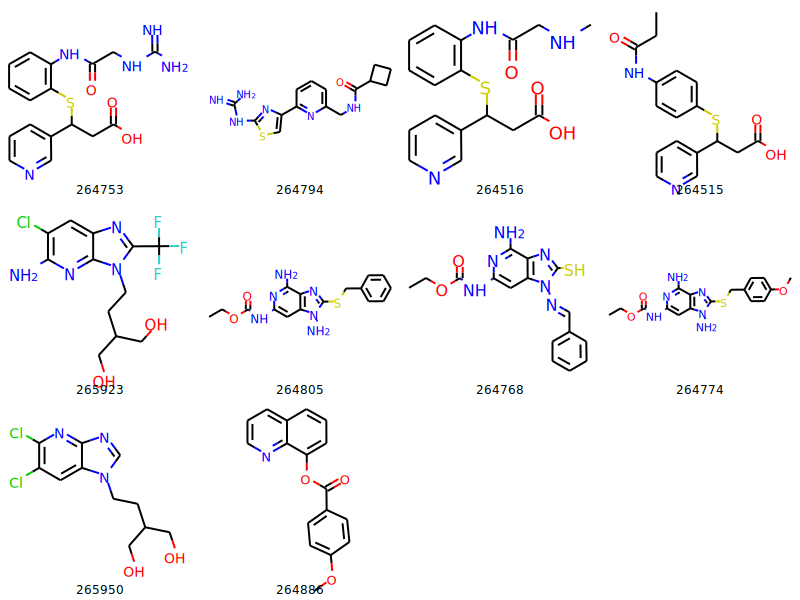

In [20]:
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

In [34]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>'*c1cccc(*)n1'::mol limit 10 ;

0 rows affected.


10 rows affected.


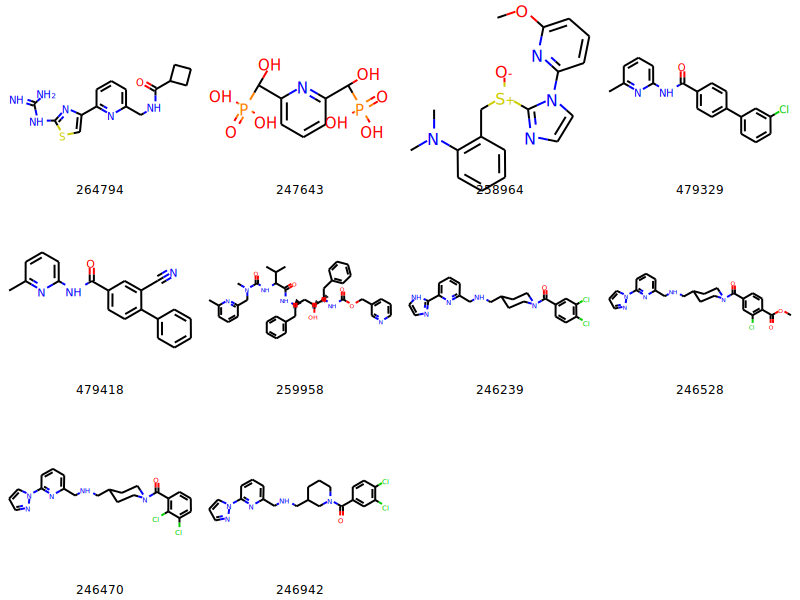

In [37]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol) limit 10 ;
#if len(data):            
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

10 rows affected.


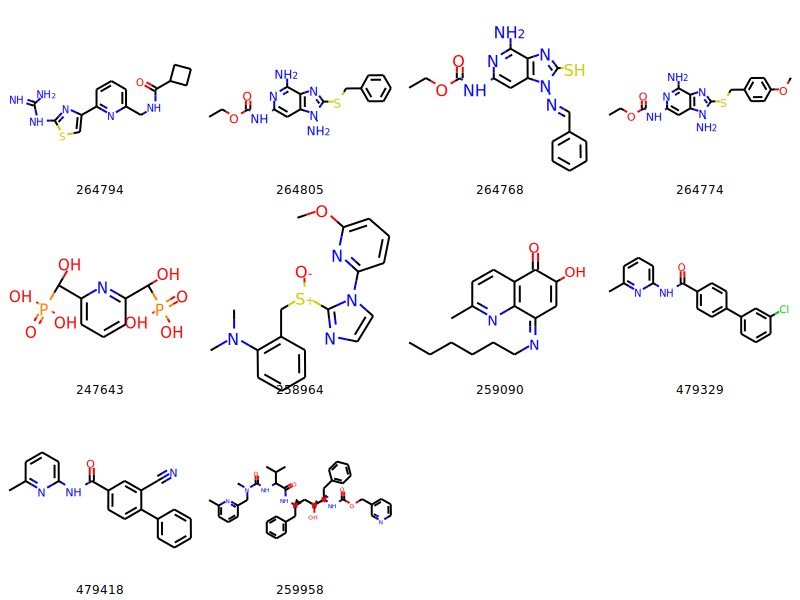

In [40]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol,\
                                                         '{"adjustDegree"\:false}') limit 10 ;
#if len(data):            
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

10 rows affected.


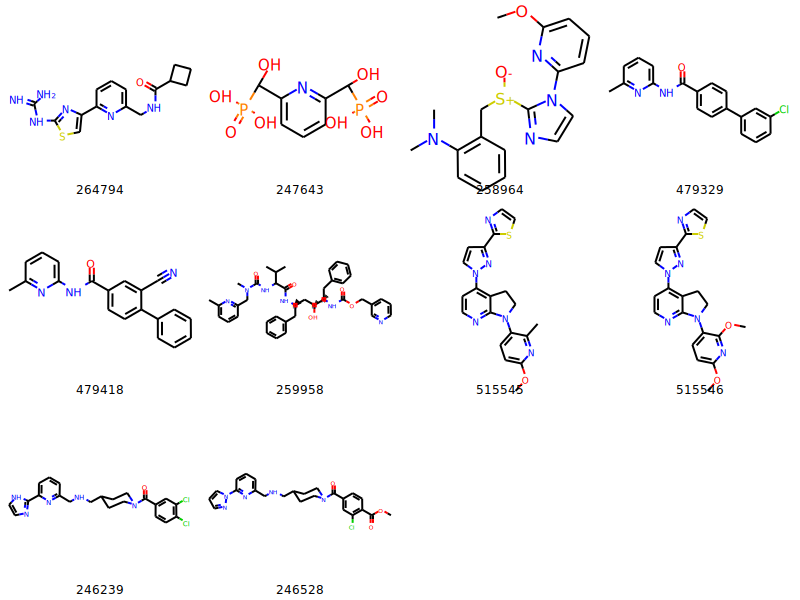

In [42]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1'::mol,\
                                                         '{"adjustDegree"\:false,\
                                                          "adjustRingCount"\:true}') limit 10 ;
#if len(data):            
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

In [45]:
m1 = Chem.MolFromSmiles('[nH]1cccn1')
for p in Chem.FindAllPathsOfLengthN(m1, 5,useBonds=False):
    print(list(p))

[0, 1, 2, 3, 4]
[0, 4, 3, 2, 1]
[1, 0, 4, 3, 2]
[2, 1, 0, 4, 3]
[3, 2, 1, 0, 4]


In [44]:
for p in Chem.FindAllSubgraphsOfLengthN(m1, 5, ):
    print(list(p))

[0, 1, 2, 3, 4]
